In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import optuna
import time

In [ ]:
start=time.time()
data = pd.read_csv('newdata.csv')
data = data.sample(n=10000)
data = data.drop(['subregion','parent'], axis=1)
data['time'] = pd.to_datetime(data['time'])

# Extract features from 'time'
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek
data['day_of_month'] = data['time'].dt.day
data.sort_values('time', inplace=True)
# Drop original 'time' column
data = data.drop(['time'], axis=1)

# Normalize numerical features
scaler = MinMaxScaler()
data[['hour', 'day_of_week', 'day_of_month']] = scaler.fit_transform(data[['hour', 'day_of_week', 'day_of_month']])

features = data.drop(['value'], axis=1).values
target = data['value'].values

X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, shuffle=False)

class SolarDataset(Dataset):
    def __init__(self, features, labels, sequence_length=20):
        self.features = [features[i: i+sequence_length] for i in range(len(features)-sequence_length+1)]
        self.labels = labels[sequence_length-1:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor([self.labels[idx]])

train_dataset = SolarDataset(X_train, y_train)
val_dataset = SolarDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

class ConvLSTM(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, hidden_dim, num_layers, dropout=0.3):
        super(ConvLSTM, self).__init__()

        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Convert (batch_size, seq_length, n) to (batch_size, n, seq_length) for CNN
        x = x.transpose(1, 2)
        c_out = self.cnn(x)
        # Transpose to (batch_size, seq_length, num_filters) for LSTM
        c_out = c_out.transpose(1, 2)

        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)

        lstm_out, _ = self.lstm(c_out, (h0, c0))
        y_pred = self.fc(lstm_out[:, -1, :])
        return y_pred

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvLSTM(input_size=X_train.shape[1], num_filters=64, kernel_size=3, hidden_dim=128, num_layers=2)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

num_epochs = 400
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(math.sqrt(train_loss))
    val_losses.append(math.sqrt(val_loss))
    scheduler.step(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {math.sqrt(train_loss)}, Validation Loss: {math.sqrt(val_loss)}')
end = time.time()
print(end-start)

Epoch: 1, Training Loss: 2088.1618586690065, Validation Loss: 2052.941722928816
Epoch: 2, Training Loss: 2070.878606292508, Validation Loss: 2036.629443942978
Epoch: 3, Training Loss: 2054.7684594620387, Validation Loss: 2020.6983641880493
Epoch: 4, Training Loss: 2039.4474643883327, Validation Loss: 2004.956284214921
Epoch: 5, Training Loss: 2023.5022713108083, Validation Loss: 1988.9436205700883
Epoch: 6, Training Loss: 2007.816931395888, Validation Loss: 1972.8291621997598
Epoch: 7, Training Loss: 1991.8487231715164, Validation Loss: 1956.9689717651665
Epoch: 8, Training Loss: 1975.8936479476824, Validation Loss: 1941.2188472460352
Epoch: 9, Training Loss: 1960.6748781988308, Validation Loss: 1925.5703176947595
Epoch: 10, Training Loss: 1945.2849590741198, Validation Loss: 1910.0087843912168
Epoch: 11, Training Loss: 1929.742258955843, Validation Loss: 1894.5091989321957
Epoch: 12, Training Loss: 1914.6719698162399, Validation Loss: 1879.052023778085
Epoch: 13, Training Loss: 1899.3

Epoch: 103, Training Loss: 681.0373027595479, Validation Loss: 605.0441909763899
Epoch: 104, Training Loss: 670.4036774585891, Validation Loss: 593.3818020074672
Epoch: 105, Training Loss: 659.8013161172081, Validation Loss: 581.8577950836413
Epoch: 106, Training Loss: 649.6816859047206, Validation Loss: 570.4464611780536
Epoch: 107, Training Loss: 639.4373767226937, Validation Loss: 559.1896940317215
Epoch: 108, Training Loss: 629.3504098473283, Validation Loss: 548.0250221469761
Epoch: 109, Training Loss: 619.762472645771, Validation Loss: 537.0284686204922
Epoch: 110, Training Loss: 609.8234437113746, Validation Loss: 526.1521873412213
Epoch: 111, Training Loss: 600.5115500554506, Validation Loss: 515.4352177623075
Epoch: 112, Training Loss: 591.082767470005, Validation Loss: 504.8122777190419
Epoch: 113, Training Loss: 581.8548313368207, Validation Loss: 494.4440576640336
Epoch: 114, Training Loss: 572.7716846615238, Validation Loss: 484.18902933568444
Epoch: 115, Training Loss: 56

Epoch: 204, Training Loss: 388.45854355709565, Validation Loss: 266.8710790251737
Epoch: 205, Training Loss: 381.0217795612214, Validation Loss: 260.7975797110957
Epoch: 206, Training Loss: 378.1654066840329, Validation Loss: 261.2045611578352
Epoch: 207, Training Loss: 376.68390370773744, Validation Loss: 258.8479174972075
Epoch: 208, Training Loss: 374.84281363993097, Validation Loss: 261.3439472613844
Epoch: 209, Training Loss: 372.8023948337108, Validation Loss: 255.03904332762812
Epoch: 210, Training Loss: 372.237966393811, Validation Loss: 257.54693213669657
Epoch: 211, Training Loss: 370.49610625484314, Validation Loss: 255.46487289896092
Epoch: 212, Training Loss: 368.8696718524037, Validation Loss: 259.0876206253211
Epoch: 213, Training Loss: 368.4570992666582, Validation Loss: 253.8712009928428
Epoch: 214, Training Loss: 367.8552597489942, Validation Loss: 252.31362754648296
Epoch: 215, Training Loss: 366.83534334221395, Validation Loss: 256.7795933804182
Epoch: 216, Training

Epoch: 304, Training Loss: 333.81751573651735, Validation Loss: 244.86718583157813
Epoch: 305, Training Loss: 333.2100606224248, Validation Loss: 242.44400412484677
Epoch: 306, Training Loss: 333.28114530003046, Validation Loss: 243.20735347491902
Epoch: 307, Training Loss: 333.06545832801396, Validation Loss: 242.30654215366062
Epoch: 308, Training Loss: 332.67308864146196, Validation Loss: 244.61112506907875
Epoch: 309, Training Loss: 332.00630627482064, Validation Loss: 244.15406309790902
Epoch: 310, Training Loss: 332.02160660113674, Validation Loss: 244.4419091792683
Epoch: 311, Training Loss: 331.8409759395304, Validation Loss: 242.58331845708022
Epoch: 312, Training Loss: 331.6235853249132, Validation Loss: 242.340079408466
Epoch: 313, Training Loss: 331.49695737668543, Validation Loss: 242.19772637098433
Epoch: 314, Training Loss: 331.31166322286333, Validation Loss: 242.11139282838053
Epoch: 315, Training Loss: 331.2220420277008, Validation Loss: 244.57240474819417
Epoch: 316,

KeyboardInterrupt: 

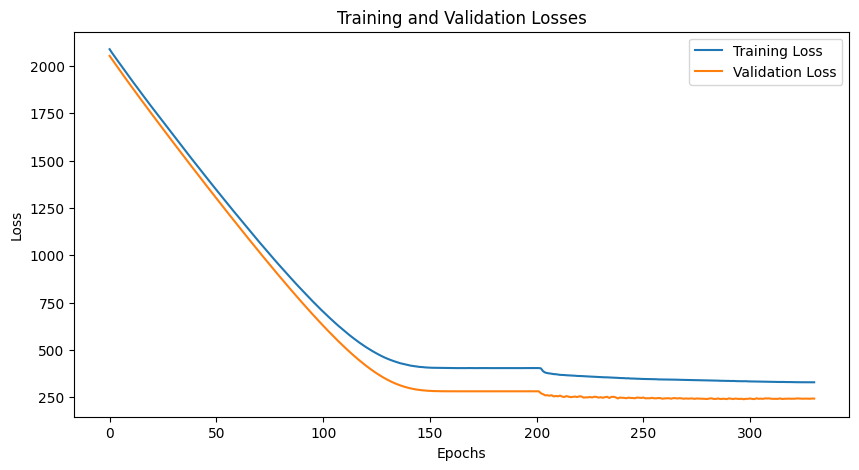

In [ ]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()